基底行列を作成中...
L1ノルム最小化を計算中... (Compressed Sensing)
L2ノルム最小化を計算中... (Least Squares)


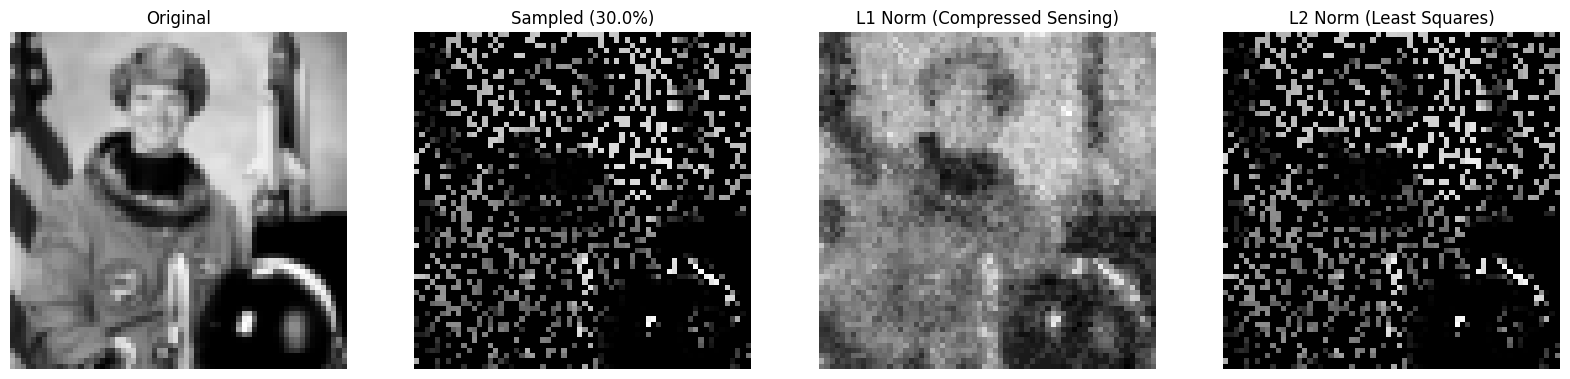

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.fftpack import dct, idct
from skimage import data, color, transform

# --- 1. 画像の準備 ---
img_orig = data.astronaut()
img_orig = color.rgb2gray(img_orig)
# 計算負荷のため 64x64 にリサイズ
N = 64
img = transform.resize(img_orig, (N, N))

# 画像を1次元ベクトル化
x_true = img.flatten()
n = len(x_true)

# --- 2. 観測（ランダムサンプリング） ---
sample_ratio = 0.3 # 30%のデータのみ使用
m = int(n * sample_ratio)

# ランダムな観測インデックス
ri = np.random.choice(n, m, replace=False)
ri.sort()

# 観測データ y
y = x_true[ri]

# --- 3. 行列の準備 ---
# 2次元DCT基底辞書 (IDCT行列) を作成
def construct_idct_matrix(N):
    psi = np.zeros((N*N, N*N))
    for i in range(N*N):
        ek = np.zeros(N*N)
        ek[i] = 1
        psi[:, i] = idct(idct(ek.reshape(N, N).T, norm='ortho').T, norm='ortho').flatten()
    return psi

print("基底行列を作成中...")
Psi = construct_idct_matrix(N)
A = Psi[ri, :] # 観測行列

# --- 4. 最適化問題の定義と実行 ---

# 共通の制約条件: A * s == y (観測値と一致すること)

# 【A】 L1ノルム最小化 (圧縮センシング)
print("L1ノルム最小化を計算中... (Compressed Sensing)")
s_l1 = cp.Variable(n)
obj_l1 = cp.Minimize(cp.norm(s_l1, 1)) # ここがL1
prob_l1 = cp.Problem(obj_l1, [A @ s_l1 == y])
prob_l1.solve(solver=cp.SCS)
img_l1 = (Psi @ s_l1.value).reshape(N, N)

# 【B】 L2ノルム最小化 (最小エネルギー解 / 最小二乗的な解)
print("L2ノルム最小化を計算中... (Least Squares)")
s_l2 = cp.Variable(n)
obj_l2 = cp.Minimize(cp.norm(s_l2, 2)) # ここがL2
prob_l2 = cp.Problem(obj_l2, [A @ s_l2 == y])
prob_l2.solve(solver=cp.SCS)
img_l2 = (Psi @ s_l2.value).reshape(N, N)


# --- 5. 結果の表示 ---
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# オリジナル
ax[0].imshow(img, cmap='gray')
ax[0].set_title(f'Original')
ax[0].axis('off')

# 観測データ
img_masked = np.zeros_like(x_true)
img_masked[ri] = y
ax[1].imshow(img_masked.reshape(N, N), cmap='gray')
ax[1].set_title(f'Sampled ({sample_ratio*100}%)')
ax[1].axis('off')

# L1復元 (CS)
ax[2].imshow(img_l1, cmap='gray')
ax[2].set_title('L1 Norm (Compressed Sensing)')
ax[2].axis('off')

# L2復元 (Least Squares)
ax[3].imshow(img_l2, cmap='gray')
ax[3].set_title('L2 Norm (Least Squares)')
ax[3].axis('off')

plt.show()